<a href="https://colab.research.google.com/github/AudeSportisse/website/blob/master/static/how-to/python/Howtoimpute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <span style="font-size:3em">How to impute missing values in Python ?</span> 

**Aude Sportisse, Boris Muzellec**

The problem of missing data is ubiquitous in the practice of data analysis. Main approaches for handling missing data include imputation methods. In this Notebook, we first describe the main imputation methods available on R packages on synthetic data. Then, we compare them on both synthetic data for different missing-data mechanisms and percentage of missing values. Finally, we propose a function giving the comparison of the methods in one particular setting (missing-data mechanism, percentage of missing values) for a list of (complete) real datasets. 

## Description of imputation methods on synthetic data

In this section we provide, for some of the main classes and functions in Python (the list is of course not thorough) to impute missing values, links to tutorials if any, as well as a description of their main functionalities and reusable code. The goal is not to describe all the methods precisely, as many resources are already available, but rather to provide an overview of several imputation options. The methods we focus on are gathered in the table below.

| Class (or function)      | Data Types    | Underlying Method   | Imputation | Comments |
| ------------- |:--------------| ------------------- |------------|--------------|
| SingleImputer with strategy='mean' (default), sklearn.impute    | quantitative        |imputation by the mean| single| Easiest method |
| softImpute function (mimics R into Python)    | quantitative  |low-rank matrix completion | single| Strong theoretical guarantees, regularization parameter to tune |
| IterativeImputer with BayesianRidge (default), sklearn.impute         | mixed         |imputation by chained equations | single   |  Very flexible to data types, no parameter to tune |
| IterativeImputer with ExtraTreesRegressor, sklearn.impute    | mixed         |random forests| single| Requires large sample sizes, no parameter to tune |
| Sinkhorn imputation    | quantitative        |optimal transport| single|  |



In [1]:
!pip install wget 
!pip install geomloss
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge


## Downoald additional code
import wget
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/softimpute.py')
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/imputers.py')
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/data_loaders.py')
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')
wget.download('https://raw.githubusercontent.com/R-miss-tastic/website/master/static/how-to/python/produceNA.py')
wget.download('https://raw.githubusercontent.com/R-miss-tastic/website/master/static/how-to/python/tools.py')
wget.download('https://raw.githubusercontent.com/R-miss-tastic/website/master/static/how-to/python/MIWAE_functions.py')
from softimpute import softimpute, cv_softimpute
from imputers import OTimputer
from data_loaders import * 

import numpy as np

import pandas as pd

from utils import *

import torch
import torchvision
import torch.nn as nn
import torch.distributions as td
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat

import matplotlib.pyplot as plt

from produceNA import *

from tools import color_imputedvalues_orange

from itertools import product 

from sklearn.preprocessing import scale

import os

from MIWAE_functions import *

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=da1cd3ac9b6f3d9f16f437f69c1d85d4afd08cbcf6c08382b6987bd7fd8db83d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


Let us consider a Gaussian data matrix of size $n$ times $p$. 

In [2]:
#### Simulation of the data matrix ####

np.random.seed(0)  # fix the seed 

n = 1000 
p = 10 

mean = np.repeat(0, p) 
cov = 0.5 * (np.ones((p,p)) + np.eye(p)) 
x_comp = np.random.multivariate_normal(mean, cov, size = n)

In [3]:
pd.DataFrame(x_comp).head()

,0,1,2,3,4,5,6,7,8,9
0,-1.039823,-1.406895,-0.701245,-0.243445,-0.512836,-2.146725,-2.522237,-0.761441,-2.379464,-1.368450
1,0.868731,-0.006509,0.654021,-0.705815,-0.288841,-0.423724,-0.259798,0.275939,-1.031320,-0.150938
2,2.331809,2.866483,2.478842,2.833329,2.348079,2.431913,0.914379,0.759329,1.057632,0.911685
3,0.138767,-0.401317,0.912531,-0.471823,-1.372814,0.072473,0.632320,-0.727102,0.330743,-0.262900
4,-0.174949,-0.192462,0.099167,1.580241,1.062209,-0.191656,0.591569,1.045559,2.122082,1.834517


We introduce some missing (here MCAR) values in the data matrix using the function `produce_NA` given in the Python Notebook [How to generate missing values in Python ?](https://rmisstastic.netlify.app/how-to/python/generate_html/how%20to%20generate%20missing%20values). 

In [4]:
#### Introduction of missing values ####

perc_miss = 0.3 # 30% NA

XproduceNA =  produce_NA(x_comp, p_miss=perc_miss, mecha="MCAR")
X_miss = XproduceNA['X_incomp']
x_miss = X_miss.numpy()
Mask = XproduceNA['mask'] # True for missing values, False for others

In [6]:
pd.DataFrame(x_miss).head().style.highlight_null(null_color='orange')

,0,1,2,3,4,5,6,7,8,9
0,-1.039823,-1.406895,nan,-0.243445,nan,nan,-2.522237,-0.761441,nan,-1.368450
1,nan,-0.006509,nan,-0.705815,-0.288841,-0.423724,nan,nan,-1.031320,-0.150938
2,2.331809,2.866483,nan,2.833329,2.348079,2.431913,nan,0.759329,nan,0.911685
3,nan,-0.401317,0.912531,-0.471823,-1.372814,0.072473,0.632320,-0.727102,0.330743,-0.262900
4,nan,nan,0.099167,1.580241,1.062209,-0.191656,nan,nan,nan,1.834517


### Imputation by the mean

The [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) class provides basic strategies for imputing missing values as the mean imputation. This is a naive imputation, which serves as benchmark in the sequel. 

In [7]:
x_mean = SimpleImputer().fit_transform(x_miss)

In [8]:
pd.DataFrame(x_mean).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,-1.039823,-1.406895,-0.013347,-0.243445,0.046110,0.039072,-2.522237,-0.761441,0.067844,-1.368450
1,0.053043,-0.006509,-0.013347,-0.705815,-0.288841,-0.423724,0.104904,-0.039650,-1.031320,-0.150938
2,2.331809,2.866483,-0.013347,2.833329,2.348079,2.431913,0.104904,0.759329,0.067844,0.911685
3,0.053043,-0.401317,0.912531,-0.471823,-1.372814,0.072473,0.632320,-0.727102,0.330743,-0.262900
4,0.053043,0.000098,0.099167,1.580241,1.062209,-0.191656,0.104904,-0.039650,0.067844,1.834517


### softimpute

The function softimpute (original article of [Hastie and al.](http://jmlr.org/papers/volume16/hastie15a/hastie15a.pdf)) can be used to impute quantitative data. The function coded here in Python mimics the function softimpute of the [R package softImpute](https://cran.r-project.org/web/packages/softImpute/index.html). It fits a low-rank matrix approximation to a matrix with missing values via nuclear-norm regularization. The main arguments are the following. 

* `X`: the data set with missing values (matrix).

* `lambda`: the nuclear-norm regularization parameter.

To calibrate the parameter lambda, one may perform cross-validation, coded in the function cv_softimpute which takes in argument the data set with missing values and the length of the grid on which cross-validation is performed.

In [9]:
cv_error, grid_lambda = cv_softimpute(x_miss, grid_len=15)
lbda = grid_lambda[np.argmin(cv_error)]
x_soft = softimpute((x_miss), lbda)[1]

In [10]:
pd.DataFrame(x_soft).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,-1.039823,-1.406895,-0.673532,-0.243445,-0.725813,-0.741566,-2.522237,-0.761441,-0.782105,-1.368450
1,-0.266467,-0.006509,-0.315405,-0.705815,-0.288841,-0.423724,-0.275906,-0.244537,-1.031320,-0.150938
2,2.331809,2.866483,1.473708,2.833329,2.348079,2.431913,1.418468,0.759329,1.421111,0.911685
3,-0.030437,-0.401317,0.912531,-0.471823,-1.372814,0.072473,0.632320,-0.727102,0.330743,-0.262900
4,0.517373,0.598064,0.099167,1.580241,1.062209,-0.191656,0.545584,0.493802,0.475720,1.834517


### Iterative chained equations

Iterative chained equations methods consist in (iterative) imputation using conditional expectation. The [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) class provides such methods and is inspired by the [mice](https://cran.r-project.org/web/packages/mice/index.html)  package in R but differs from it by returning a single imputation instead of multiple imputations. 

The main arguments are

* `estimator`: the estimator to use for the imputation. By default, it is the BayesianRidge estimator which does a regularized linear regression.

*  `random_state`: maximum number of imputation rounds to perform. (The last imputations are returned.)

*  `max_iter`: seed of the pseudo random number generator to use.

The method fit_transform allows to fit the imputer on the incomplete matrix and return the complete matrix. 

In [11]:
x_ice = IterativeImputer(random_state=0, max_iter=50).fit_transform(x_miss)

In [12]:
pd.DataFrame(x_ice).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,-1.039823,-1.406895,-0.908809,-0.243445,-1.010098,-1.027847,-2.522237,-0.761441,-1.094620,-1.368450
1,-0.341876,-0.006509,-0.515132,-0.705815,-0.288841,-0.423724,-0.276307,-0.338593,-1.031320,-0.150938
2,2.331809,2.866483,2.181428,2.833329,2.348079,2.431913,2.024793,0.759329,2.020790,0.911685
3,0.026798,-0.401317,0.912531,-0.471823,-1.372814,0.072473,0.632320,-0.727102,0.330743,-0.262900
4,0.958952,1.062465,0.099167,1.580241,1.062209,-0.191656,1.035532,0.764540,0.697045,1.834517


Another estimor can be used, the ExtraTreesRegressor estimator, which trains iterative random forest instead of doing iterative regression and mimics the [missForest](https://cran.r-project.org/web/packages/missForest/missForest.pdf) in R. [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor) fits a number of randomized extra-trees and averages the results. It comes from the module sklearn.ensemble. Its main arguments are the number of trees in the forest and the random state which allows to control the sources of randomness. 

In [13]:
estimator_rf = ExtraTreesRegressor(n_estimators=10, random_state=0)
x_rf = IterativeImputer(estimator=estimator_rf, random_state=0, max_iter=50).fit_transform(x_miss)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [14]:
pd.DataFrame(x_rf).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,-1.039823,-1.406895,-0.748921,-0.243445,-0.946926,-0.690089,-2.522237,-0.761441,-0.860885,-1.368450
1,-0.102529,-0.006509,0.208728,-0.705815,-0.288841,-0.423724,-0.536785,0.017267,-1.031320,-0.150938
2,2.331809,2.866483,1.848984,2.833329,2.348079,2.431913,2.061871,0.759329,2.124581,0.911685
3,-0.198338,-0.401317,0.912531,-0.471823,-1.372814,0.072473,0.632320,-0.727102,0.330743,-0.262900
4,0.512157,1.316051,0.099167,1.580241,1.062209,-0.191656,1.402173,0.675989,1.071837,1.834517


### Sinkhorn imputation

Sinkhorn imputation can be used to impute quantitative data. It relies on the idea that two batches extracted randomly from the same dataset should share the same distribution and consists in minimizing OT distances between batches. More details can be found in the original [article](https://arxiv.org/pdf/2002.03860.pdf) and the code is provided [here](https://github.com/BorisMuzellec/MissingDataOT).

The main argument are

* `eps`: sinkhorn regularization parameter. If the batch size is larger than half the dataset's size, it will be redefined in the imputation methods.

* `lr` : learning rate.

* `batchsize` : size of the batches on which the sinkhorn divergence is evaluated.

* `niter`: number of gradient updates for each model within a cycle.


To set the regularization, one uses the function `pick_epsilon` which takes a multiple of the median distance.
The method fit_transform allows to fit the imputer on the incomplete matrix and return the complete matrix. 



In [15]:
X_true = torch.from_numpy(x_comp).double()

eps = pick_epsilon(X_miss)

sk_imputer = OTimputer(eps=eps, batchsize=128, lr=0.01, niter=15)
sk_imp, _, _ = sk_imputer.fit_transform(X_miss, X_true=X_true)

In [16]:
sk_imp_np = sk_imp.detach().numpy()
pd.DataFrame(sk_imp_np).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,-1.039823,-1.406895,-0.178513,-0.243445,-0.217675,-0.133234,-2.522237,-0.761441,-0.002799,-1.368450
1,0.151138,-0.006509,-0.113982,-0.705815,-0.288841,-0.423724,0.201374,-0.040908,-1.031320,-0.150938
2,2.331809,2.866483,0.184869,2.833329,2.348079,2.431913,0.089948,0.759329,-0.001308,0.911685
3,0.148767,-0.401317,0.912531,-0.471823,-1.372814,0.072473,0.632320,-0.727102,0.330743,-0.262900
4,0.108655,0.192918,0.099167,1.580241,1.062209,-0.191656,0.182226,0.061255,0.218038,1.834517


### MIWAE

MIWAE imputes missing values with a deep latent variable model based on importance weighted variational inference. The original article is [here](http://proceedings.mlr.press/v97/mattei19a/mattei19a.pdf) and its code is available [here](https://github.com/pamattei/miwae). 

The main arguments are

* `X_miss`: the data set with missing values (tensor).

*  `h`: number of hidden units in multi-layer
perceptrons (by default, $h=128$).

*  `d`: dimension of the latent space (by default $d=1$).

* `K`: number of importance sampling during training (by default $K=20$).

* `bs`: batch size (by default $bs=64$).

* `n_epochs`: number of epochs (by default $n_epochs=2002$).


In [17]:
x_miwae = MIWAE(X_miss)

In [19]:
pd.DataFrame(x_miwae).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2,3,4,5,6,7,8,9
0,-1.039823,-1.406895,-1.215163,-0.243445,-1.294146,-0.943358,-2.522237,-0.761441,-1.306378,-1.368450
1,-0.808020,-0.006509,-0.291717,-0.705815,-0.288841,-0.423724,-0.398311,-0.133663,-1.031320,-0.150938
2,2.331809,2.866483,2.532821,2.833329,2.348079,2.431913,2.859528,0.759329,2.291800,0.911685
3,-0.257690,-0.401317,0.912531,-0.471823,-1.372814,0.072473,0.632320,-0.727102,0.330743,-0.262900
4,0.947291,0.910259,0.099167,1.580241,1.062209,-0.191656,1.286668,0.975503,0.421317,1.834517


## Numerical experiments to compare the different methods

### Synthetic data



We compare the methods presented above for different percentage of missing values and for different missing-data mechanisms: 

* Missing Completely At Random (MCAR) if the probability of being missing is the same for all observations

* Missing At Random (MAR) if the probability of being missing only depends on observed values.

* Missing Not At Random (MNAR) if the unavailability of the data depends on both observed and unobserved data such as its value itself.

We compare the methods in terms of mean squared error (MSE), i.e.:
$$MSE(X^{imp}) = \frac{1}{n_{NA}}\sum_{i}\sum_{j} 1_{X^{NA}_{ij}=NA}(X^{imp}_{ij} - X_{ij})^2$$
where $n_{NA} = \sum_{i}\sum_{j} 1_{X^{NA}_{ij}=NA}$ is the number of missing entries in $X^{NA}$.

Note that in order to evaluate this error, we need to know the true values of the missing entries.


The function **HowToImpute** compares the methods above with the naive imputation by the mean in terms of MSE on a complete dataset. More particularly, the function allows to introduce missing values on the complete dataset using different percentages of missing values and missing-data mechanisms and gives the MSE of the methods for the different missing-value settings. The final MSE for one specific missing-value setting is computed by aggregating the MSE's obtained for several simulations, where the stochasticity comes from the process of drawing several times the missing-data pattern.

The arguments are the following. 

* `X`: the complete data set where the missing values will be introduced (matrix).

* `perc.list`: list containing the different percentage of missing values. 

* `mecha.list`: list containing the different missing-data mechanisms ("MCAR","MAR", "MNAR"). 

* `nbsim`: number of simulations performed. 

It returns a table containing the mean of the results for the simulations performed. 

In [24]:
def HowToImpute(x_comp , perc_list , mecha_list , nbsim):
    """
    Compare in terms of MSE several imputation methods for different percentages of missing values and missing-data mechanisms.
    
    Parameters
    ----------
    x_comp : the complete data set where the missing values will be introduced (numpy array).
    perc_list : list containing the different percentage of missing values.
    mecha_list : list containing the different missing-data mechanisms ("MCAR","MAR" or "MNAR").
    nbsim : number of simulations performed.
    
    Returns
    -------
    df: dataframe containing the mean of the MSEs for the simulations performed. 
    """
    mecha_perc_list = pd.DataFrame([(mecha,perc) for mecha, perc in product(mecha_list,perc_list)])
    df = mecha_perc_list.apply(ComparMethods, axis=1, x_comp=x_comp, nbsim=nbsim)
    df.index = mecha_perc_list.apply(lambda x : x[0] + " " + str(x[1]), axis=1)
    
    return df

def ComparMethods(mecha_perc, x_comp, nbsim):
    """
    Compare in terms of MSE several imputation methods for a given percentage of missing values and a given missing-data mechanism.
    
    Parameters
    ----------
    mecha_perc : list containing the missing-data mechanism and the percentage of missing values to be used for introducing missing values. 
    x_comp : the complete data set where the missing values will be introduced (matrix).
    nbsim : number of simulations performed.
    
    Returns
    -------
    df: dataframe containing the mean of the MSEs.
    """
    mecha = mecha_perc[0]
    perc = mecha_perc[1]
    
    RMSE_results = pd.DataFrame()
    Methods = ['mean', 'softimpute', 'ice', 'rf','sk','miwae']
    for meth in Methods:
        RMSE_results[meth]=[]
    
    for sim in range(0,nbsim):
        ## Introduction NA
        if mecha == "MAR":
            XproduceNA = produce_NA(x_comp, perc, mecha, p_obs=0.5)
        elif mecha == "MNAR":
            XproduceNA = produce_NA(x_comp, perc, mecha, p_obs=0.5, opt="logistic")
        else: 
            XproduceNA = produce_NA(x_comp, perc, mecha)
        mask = XproduceNA['mask'].numpy()
        x_miss = XproduceNA['X_incomp'].numpy()
        
        ## Mean
        x_mean = SimpleImputer().fit_transform(x_miss)
        rmse_mean = RMSE(x_mean, x_comp, mask)

        ## SoftImpute
        cv_error, grid_lambda = cv_softimpute(x_miss, grid_len=15)
        lbda = grid_lambda[np.argmin(cv_error)]
        x_soft = softimpute((x_miss), lbda)[1]
        rmse_soft = RMSE(x_soft, x_comp, mask)

        ## Ice
        x_ice = IterativeImputer(random_state=0, max_iter=50).fit_transform(x_miss)
        rmse_ice = RMSE(x_ice, x_comp, mask)

        ## Random Forests
        estimator_rf = ExtraTreesRegressor(n_estimators=10, random_state=0)
        x_rf = IterativeImputer(estimator=estimator_rf, random_state=0, max_iter=50).fit_transform(x_miss)
        rmse_rf = RMSE(x_rf, x_comp, mask)
        
        ## Sinkhorn imputation
        X_true = torch.from_numpy(x_comp).double()
        X_miss = XproduceNA['X_incomp']
        batchsize = 128
        lr = 1e-2
        epsilon = pick_epsilon(X_miss)
        sk_imputer = OTimputer(eps=epsilon, batchsize=batchsize, lr=lr, niter=2000)
        sk_imp, _, _ = sk_imputer.fit_transform(X_miss, verbose=True, report_interval=500, X_true=X_true)
        rmse_sk_imp = RMSE(sk_imp.detach().numpy(), x_comp, mask)

        ## MIWAE 
        x_miwae = MIWAE(X_miss)
        rmse_miwae = RMSE(x_miwae, x_comp, mask)
        
        new_rmse = {'mean': rmse_mean, 'softimpute': rmse_soft, 'ice': rmse_ice, 'rf': rmse_rf, 'sk': rmse_sk_imp, 'miwae': rmse_miwae}
        RMSE_results = RMSE_results.append(new_rmse, ignore_index=True)

        
    return RMSE_results.mean()

In [25]:
perc_list = [0.1, 0.3, 0.5]
mecha_list = ["MCAR", "MAR", "MNAR"]

results_how_to_impute = HowToImpute(x_comp, perc_list , mecha_list , nbsim=2)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: Co

In [26]:
results_how_to_impute

,mean,softimpute,ice,rf,sk,miwae
MCAR 0.1,0.976013,0.746134,0.738572,0.801411,0.786786,0.791175
MCAR 0.3,1.008952,0.777443,0.765772,0.824355,0.807561,0.824856
MCAR 0.5,1.009450,0.799379,0.859974,0.884423,0.828306,0.846791
MAR 0.1,1.082560,0.766041,0.742462,0.813240,0.791764,0.815332
MAR 0.3,1.038425,0.763665,0.744263,0.814286,0.782858,0.802565
MAR 0.5,1.044219,0.762583,0.938679,0.846025,0.770826,0.802855
MNAR 0.1,1.050726,0.769790,0.745681,0.802360,0.785751,0.819911
MNAR 0.3,1.036790,0.779541,0.761740,0.819780,0.796749,0.821963
MNAR 0.5,1.028779,0.793372,0.880201,0.876930,0.826131,0.849127


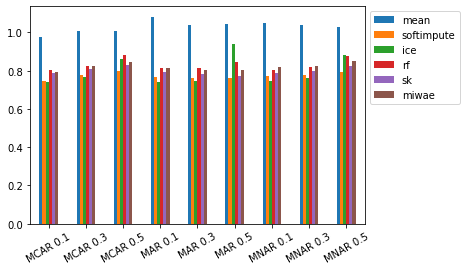

In [27]:
ax = results_how_to_impute.plot(kind="bar",rot=30)
ax.get_legend().set_bbox_to_anchor((1, 1))

### Real datasets

We will now compare the methods on real complete data set taken from [the UCI repository](http://archive.ics.uci.edu/ml) in which we will introduce missing values. In the present workflow, we propose a selection of several data sets (here, the data sets contain only quantitative variables):

- Wine Quality - Red (1599x11)
- Wine Quality - White (4898x11)
- Slump (103x9)

But you can test the methods on any complete dataset you want.


In [28]:
if not os.path.isdir('datasets'):
  os.mkdir('datasets')
wine_red = dataset_loader('wine_quality_red')
wine_white = dataset_loader('wine_quality_white')
slump = dataset_loader('concrete_slump')

You can choose to scale data prior to running the experiments, which implies that the variable have the same weight in the analysis. Scaling data may be performed on complete data sets but is more difficult for incomplete data sets. (For MCAR values, the estimations of the standard deviation can be unbiased. However, for MNAR values, the estimators will suffer from biases.)

In [29]:
sc = True
if sc:
  wine_white =  scale(wine_white)
  wine_red = scale(wine_red)
  slump = scale(slump)

In [30]:
datasets_list = dict(wine_white=wine_white, wine_red=wine_red, slump=slump)
names_dataset = ['wine_white','wine_red','slump']
perc = [0.1]
mecha = ["MCAR"]
nbsim = 2

We can then apply the **HowToImpute_real** function. It compares in terms of MSE several imputation methods for different complete datasets where missing values are introduced with a given percentage of missing values and a given missing-data mechanism.

The arguments are the following. 

* `datasets_list`: dictionnary of complete datasets.

* `perc`: percentage of missing values.

* `mecha`: missing-data mechanism ("MCAR","MAR" or "MNAR"). 

* `nbsim`: number of simulations performed. 

* `names_dataset`: list containing the names of the datasets (for plotting results).

It returns a table containing the mean of the MSEs for the simulations performed. 

In [31]:
def HowToImpute_real(datasets_list, perc, mecha, nbsim, names_dataset):
    """
    Compare in terms of MSE several imputation methods for different complete datasets where missing values are introduced with a given percentage of missing values and a given missing-data mechanism.
    
    Parameters
    ----------
    datasets_list : dictionnary of complete datasets.
    perc : percentage of missing values.
    mecha_list : missing-data mechanism ("MCAR","MAR" or "MNAR").
    nbsim : number of simulations performed.
    names_dataset : vector of the names of datasets.
    
    Returns
    -------
    res: dataframe containing the mean of the MSEs for the simulations performed. 
    """

    for dat in range(0,len(datasets_list)):
      df = HowToImpute(datasets_list[names_dataset[dat]], perc, mecha, nbsim)
      if dat==0:
        res = df
      else:
        res = pd.concat([res,df])
    res.index = names_dataset
    return(res)

In [32]:
results_how_to_impute_real = HowToImpute_real(datasets_list, perc, mecha, nbsim, names_dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: Co

In [33]:
results_how_to_impute_real

,mean,softimpute,ice,rf,sk,miwae
wine_white,1.021893,0.812990,0.787098,0.630706,0.806140,0.970664
wine_red,1.007784,0.833239,0.783270,0.631925,0.756296,0.946279
slump,0.997466,0.678515,0.580718,0.797806,0.675546,1.012789


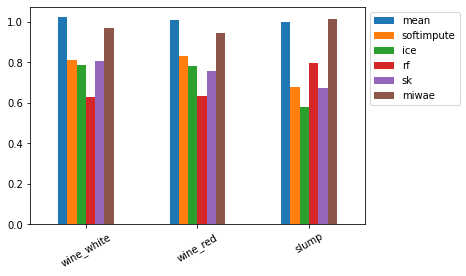

In [34]:
ax = results_how_to_impute_real.plot(kind="bar",rot=30)
ax.get_legend().set_bbox_to_anchor((1, 1))